# Visualizations for RECIST vs. PyRadiomics Measurements

## Dependencies

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

from damply import dirs 
from pathlib import Path

## Load Data

In [10]:
area = ""
dataset = "PMCC_OCTANE"

matched_pyrad_ann_file = dirs.PROCDATA / area / dataset / Path("metadata/recist_diameter_stats/matched_pyradiomics_annotations.csv")

pyrad_ann_df = pd.read_csv(matched_pyrad_ann_file)

num_ann = pyrad_ann_df.shape[0]

In [6]:
#If you want to get all dataset information, run the following code instead of the block above 
area = "Crowds_Cure_Cancer_2018Subset"
dataset = "Crowds-Cure-2018"
areas = ["Abdomen", "Abdomen", "Lung"]
datasets = ["TCIA_CPTAC-CCRCC", "TCIA_CPTAC-PDA", "TCIA_NSCLC-Radiogenomics"]

pyrad_ann_df = pd.DataFrame()
for i in range(len(areas)): 
    curr_path = dirs.PROCDATA / areas[i] / datasets[i] / Path("metadata/recist_diameter_stats/matched_pyradiomics_annotations.csv")
    curr_data = pd.read_csv(curr_path)
    pyrad_ann_df = pd.concat([pyrad_ann_df, curr_data])

pyrad_ann_df.shape[0]

126

## Visualize Raw Data

### Setting Up Label and Save Parameters

In [17]:
num_ann = pyrad_ann_df.shape[0] #Number of tumour annotations in current cohort

pyrad_feature = "original_shape_Maximum2DDiameterSlice"
pyrad_feat_label = pyrad_feature.split("_")[-1]

save_folder = Path("/home/bhkuser/bhklab/kaitlyn/recist-vs-reality/data/results/" + dataset + "/visualization/recist_vs_pyradiomics/" + pyrad_feat_label)

if not save_folder.exists(): 
    save_folder.mkdir(parents=True, exist_ok=True)

### Scatter Plot: Pyradiomics Measurement vs. RECIST Measurement

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_252943/1028563503.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("PyRadiomics " + pyrad_feat_label + " ($\mathregular{mm^3}$)")


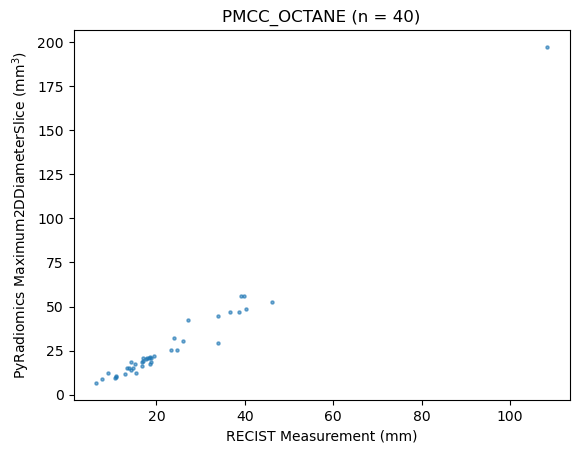

In [18]:
plt.scatter(pyrad_ann_df["AnnLongAxisLength"], pyrad_ann_df[pyrad_feature], s = 5, alpha = 0.6)
plt.xlabel("RECIST Measurement (mm)")
plt.ylabel("PyRadiomics " + pyrad_feat_label + " ($\mathregular{mm^3}$)")
plt.title(dataset + " (n = " + str(num_ann) + ")")
plt.savefig(save_folder / "RECIST_vs_PyRad_Scatter.png", bbox_inches = 'tight')

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_252943/3479260402.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Volume ($\mathregular{mm^3}$)")


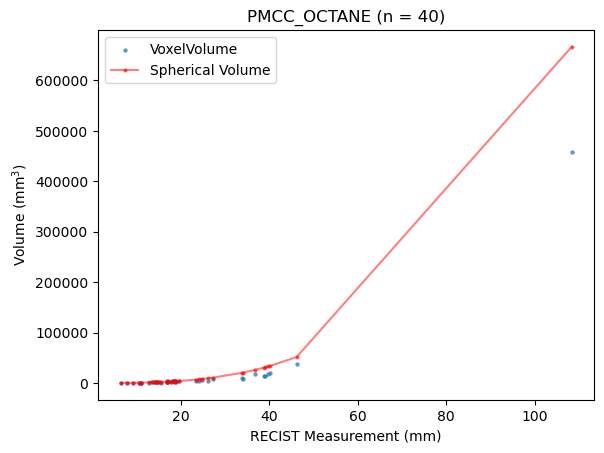

In [16]:
#Plot volume of the expected sphere to see difference between it and the actual volume 
import numpy as np

#Need to order indices for proper line graph for spherical volumes 
sorted_ann_indices = np.argsort(pyrad_ann_df["AnnLongAxisLength"].to_numpy())
sorted_ann_lengths = pyrad_ann_df["AnnLongAxisLength"].to_numpy()[sorted_ann_indices]
sphere_vols = 4/3 * np.pi * (sorted_ann_lengths/2) ** 3
# pyrad_ann_df["SphereVols"] = 4/3 * np.pi * (pyrad_ann_df["AnnLongAxisLength"]/2) ** 3

plt.scatter(pyrad_ann_df["AnnLongAxisLength"], pyrad_ann_df[pyrad_feature], s = 5, alpha = 0.6, label = pyrad_feat_label)
plt.plot(sorted_ann_lengths, sphere_vols, 'ro-', markersize = 2, alpha = 0.5, label = "Spherical Volume")
plt.xlabel("RECIST Measurement (mm)")
plt.ylabel("Volume ($\mathregular{mm^3}$)")
plt.title(dataset + " (n = " + str(num_ann) + ")")
plt.legend(loc = 'upper left')
plt.savefig(save_folder / "RECIST_vs_PyRad_Scatter_wSphereVol.png", bbox_inches = 'tight')


### Box and Violin Plots

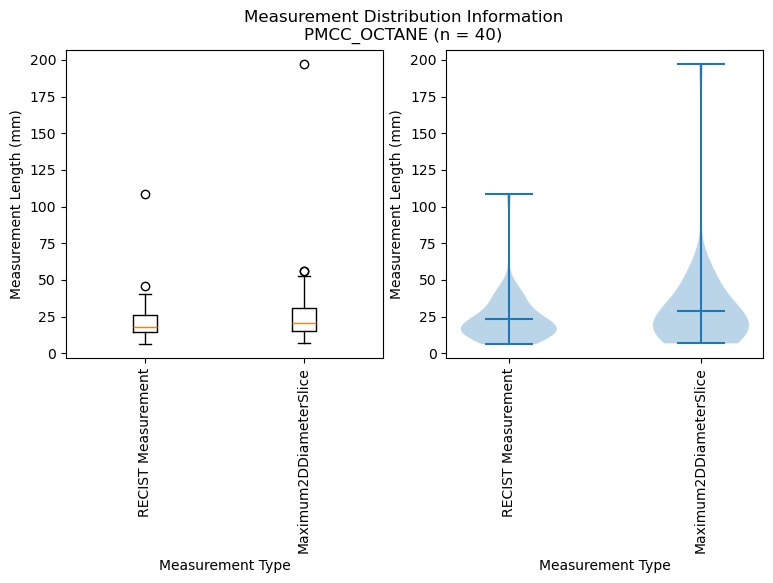

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9, 4))

#Box plot
ax[0].boxplot(pyrad_ann_df[["AnnLongAxisLength", pyrad_feature]])
ax[0].set_xticks([1, 2],["RECIST Measurement", pyrad_feat_label], rotation = 90)
ax[0].set_ylabel("Measurement Length (mm)")
ax[0].set_xlabel("Measurement Type")

#Violin plot 
ax[1].violinplot(pyrad_ann_df[["AnnLongAxisLength", pyrad_feature]],
                 showmeans=True, 
                 showmedians=False)
ax[1].set_xticks([1, 2],["RECIST Measurement", pyrad_feat_label], rotation = 90)
ax[1].set_ylabel("Measurement Length (mm)")
ax[1].set_xlabel("Measurement Type")
fig.suptitle("Measurement Distribution Information\n" + dataset + " (n = " + str(num_ann) + ")")
fig.savefig(save_folder / "Measurement_Distribution_Box_Violin.png", bbox_inches = 'tight') #Makes sure x axis doesn't get cut off

### Scatter Plot Comparison of RECIST Measurements and Pyradiomics Measurements

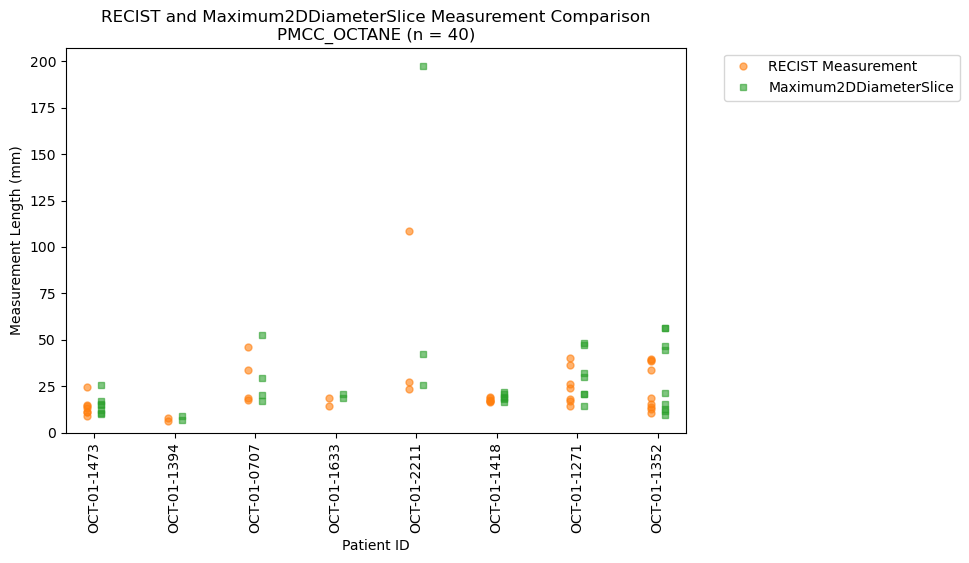

In [20]:
import matplotlib.transforms as transforms

fig, ax = plt.subplots(figsize=(8, 5)) #Change figsize to (12, 5) for NSCLC-Radiogenomics, otherwise (8, 5)

#This is to get the scatter points to appear beside each other. Have to plot temporary points for this to work for some reason
offset = lambda p: transforms.ScaledTranslation(p / 72., 0, plt.gcf().dpi_scale_trans)
temp_points = ax.plot(pyrad_ann_df["PatientID"], pyrad_ann_df["AnnLongAxisLength"], ms = 10, ls = " ", marker = ".")
for pnt in temp_points:
    pnt.remove()

#Plot the data of interest
ax.plot(pyrad_ann_df["PatientID"], pyrad_ann_df["AnnLongAxisLength"], 
            ms = 5, 
            marker = "o", 
            ls = " ", #Makes sure there are no lines connecting the dots
            transform=ax.transData + offset(-5),
            alpha = 0.6,
            label = "RECIST Measurement")
ax.plot(pyrad_ann_df["PatientID"], pyrad_ann_df[pyrad_feature], 
            ms = 5, 
            marker = "s", 
            ls = " ",
            transform=ax.transData + offset(5),
            alpha = 0.6,
            label = pyrad_feat_label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#Adjust the y axis limits in case there are some pyradiomics measurements that are much larger than the annotation length
plt.ylim((0, max(pyrad_ann_df["AnnLongAxisLength"].values.tolist() + pyrad_ann_df[pyrad_feature].values.tolist()) + 10))
plt.xticks(rotation = 90)
plt.xlabel("Patient ID")
plt.ylabel("Measurement Length (mm)")
plt.title("RECIST and " + pyrad_feat_label + " Measurement Comparison\n" + dataset + " (n = " + str(num_ann) + ")")
plt.savefig(save_folder / "RECIST_vs_PyRad_Measure_Compare.png", bbox_inches = 'tight')

### Differences in RECIST Measurement vs. Pyradiomics Measurement

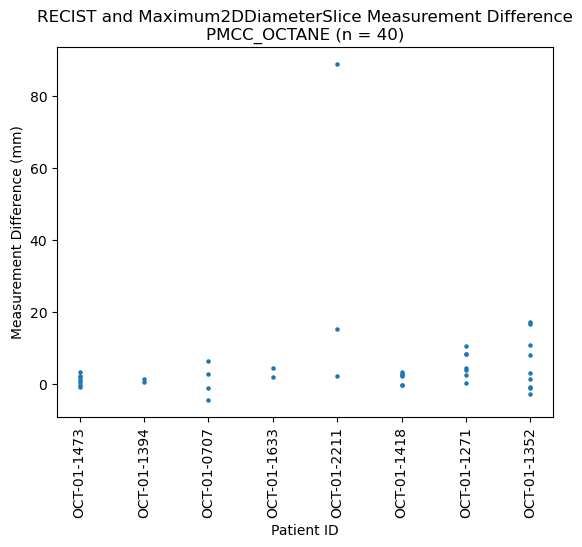

In [21]:
pyrad_ann_df["MeasurementDiff"] = pyrad_ann_df[pyrad_feature] - pyrad_ann_df["AnnLongAxisLength"]

# fig = plt.figure(figsize = (12,5)) #Only needed for NSCLC-Radiogenomics which has 74 matches
plt.scatter(pyrad_ann_df["PatientID"], pyrad_ann_df["MeasurementDiff"], s=5)
plt.xticks(rotation = 90)
plt.title("RECIST and " + pyrad_feat_label + " Measurement Difference\n" + dataset + " (n = " + str(num_ann) + ")")
plt.ylabel("Measurement Difference (mm)")
plt.xlabel("Patient ID")
plt.savefig(save_folder / "RECIST_PyRad_Measurement_Difference.png", bbox_inches = 'tight')

In [25]:
# Calculate relative measurement difference. To be calculated for Maximum2DDiameterSlice measurement only for the moment. 
print(pyrad_feature) #Just sanity check to make sure I'm using the right measurement 

pyrad_ann_df["RelativeMeasurementDiff"] = pyrad_ann_df["MeasurementDiff"] / ((pyrad_ann_df["AnnLongAxisLength"] + pyrad_ann_df[pyrad_feature])/2) * 100 

pyrad_ann_df["RelativeMeasurementDiff"].mean()

original_shape_Maximum2DDiameterSlice


np.float64(12.336274783878272)